In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=5
EPOCHS=50

In [5]:
dataset = tf.keras.utils.image_dataset_from_directory(
    './fruitdataset',
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=123,
)

Found 500 files belonging to 5 classes.


In [6]:
class_names = dataset.class_names
class_names

['Alphonso', 'Amrapali', 'Ataulfo', 'Irwin', 'Keitt']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(labels_batch.numpy())

[1 3 4 0 4 2 3 0 2 3 4 0 4 4 3 2 3 2 1 2 0 1 4 4 1 3 1 2 3 1 2 0]


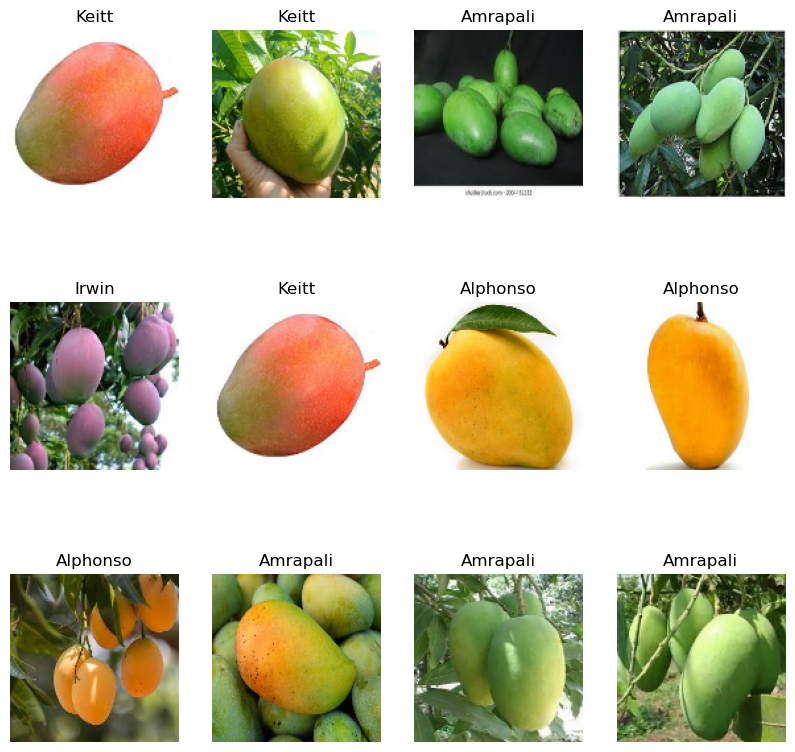

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [38]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [39]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [40]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
len(train_ds)

12

In [43]:
len(val_ds)

1

In [44]:
len(test_ds)

3

In [45]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [46]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [47]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 sequential_10 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (32, 126, 126, 16)        448       
                                                                 
 max_pooling2d_32 (MaxPooli  (32, 63, 63, 16)          0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (32, 61, 61, 32)          4640      
                                                                 
 max_pooling2d_33 (MaxPooli  (32, 30, 30, 32)          0         
 ng2D)                                               

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [49]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
12/12 [==============================] - 5s 270ms/step - loss: 1.5970 - accuracy: 0.2903 - val_loss: 1.5541 - val_accuracy: 0.3750
Epoch 2/50
12/12 [==============================] - 3s 243ms/step - loss: 1.4205 - accuracy: 0.4409 - val_loss: 1.2165 - val_accuracy: 0.5312
Epoch 3/50
12/12 [==============================] - 3s 241ms/step - loss: 1.1978 - accuracy: 0.4758 - val_loss: 1.2420 - val_accuracy: 0.4375
Epoch 4/50
12/12 [==============================] - 3s 235ms/step - loss: 0.9706 - accuracy: 0.5672 - val_loss: 1.2921 - val_accuracy: 0.4688
Epoch 5/50
12/12 [==============================] - 3s 234ms/step - loss: 0.8776 - accuracy: 0.5995 - val_loss: 0.7311 - val_accuracy: 0.6562
Epoch 6/50
12/12 [==============================] - 3s 247ms/step - loss: 0.7021 - accuracy: 0.6720 - val_loss: 0.8246 - val_accuracy: 0.6562
Epoch 7/50
12/12 [==============================] - 3s 247ms/step - loss: 0.6726 - accuracy: 0.6875 - val_loss: 0.5928 - val_accuracy: 0.7188
Epoch 

In [50]:
test_result = model.evaluate(test_ds)

3/3 [==============================] - 1s 47ms/step - loss: 0.3470 - accuracy: 0.8750


In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

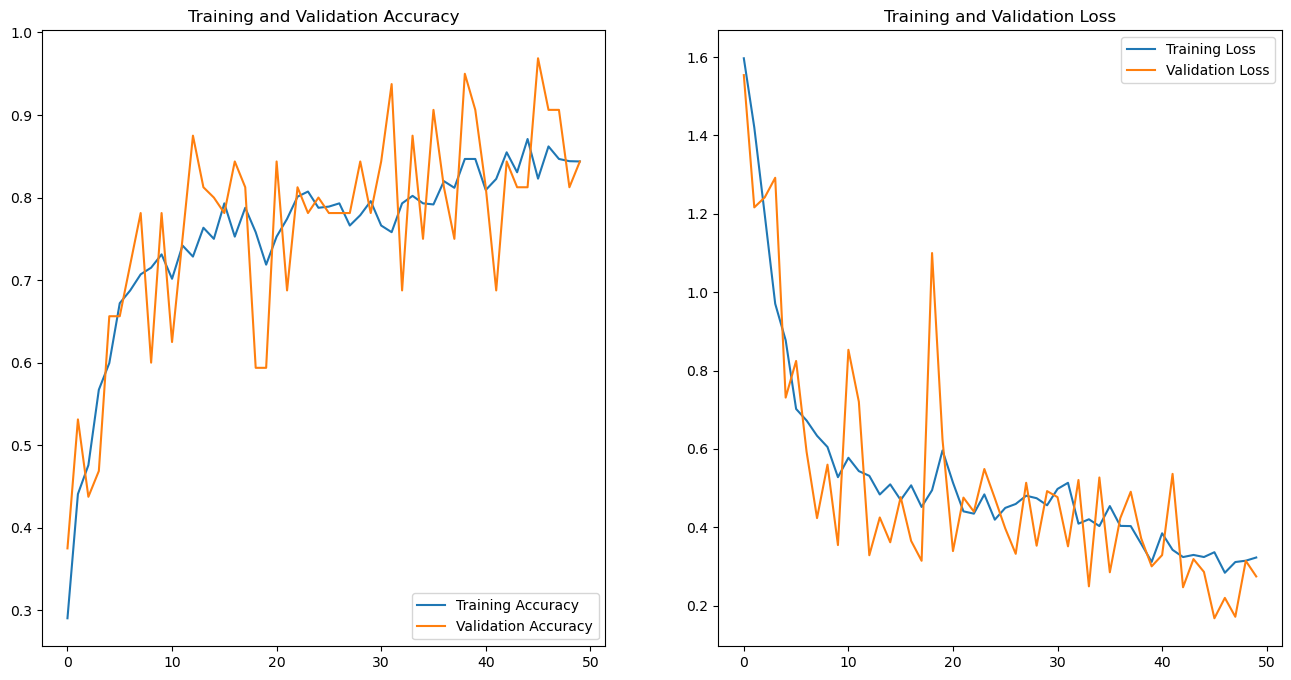

In [54]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
import numpy as np



def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 16ms/step


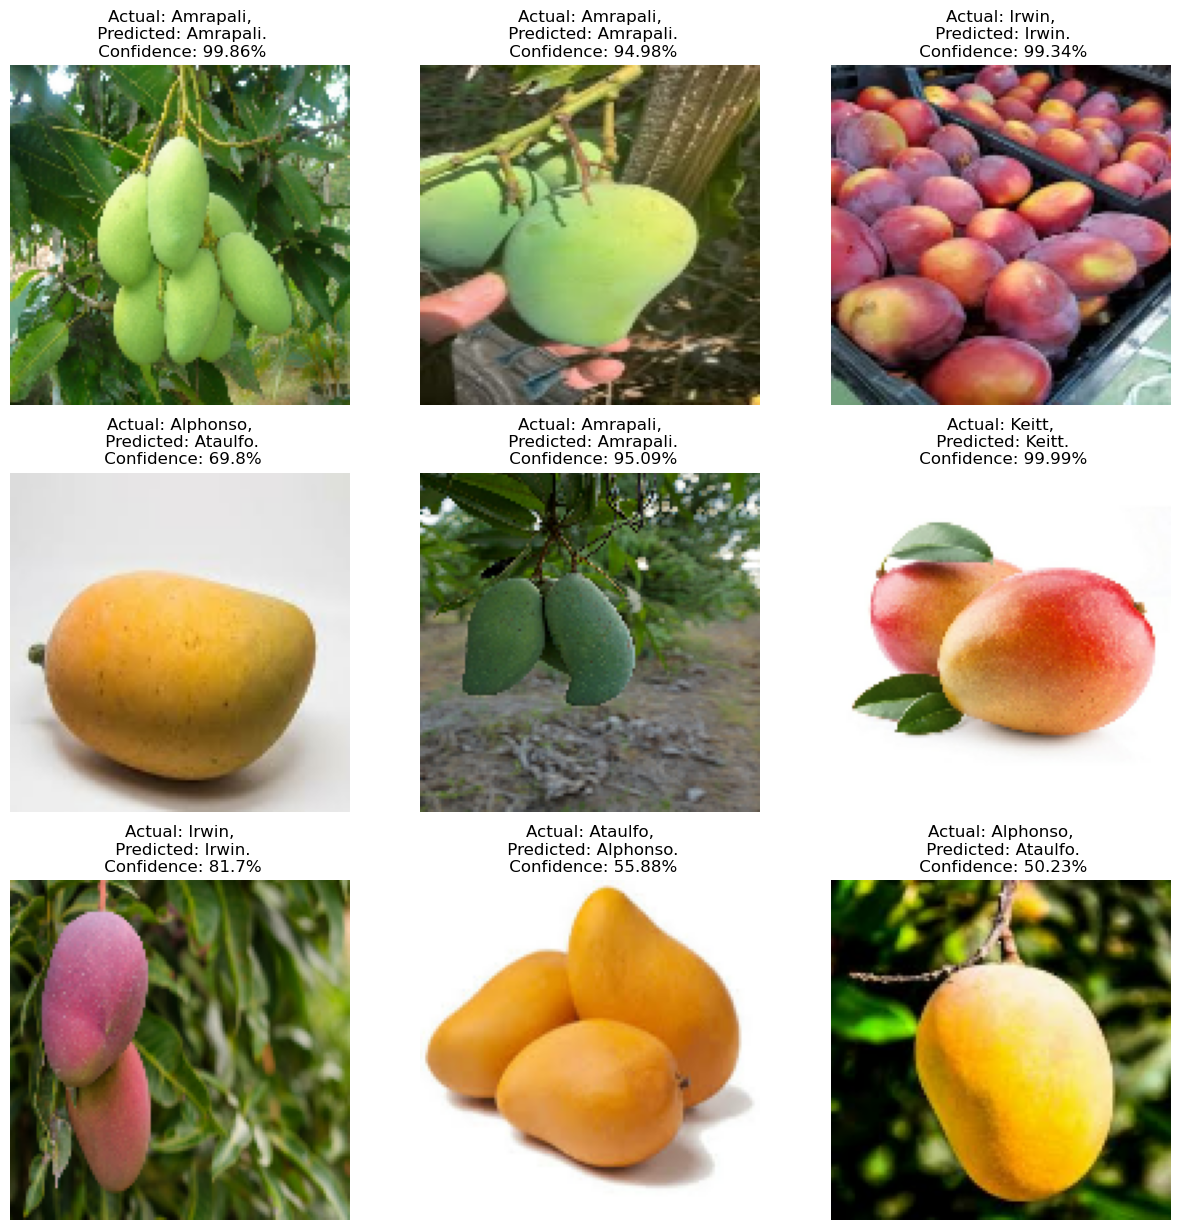

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [58]:
y_true = []
y_predicted = []


for images_batch, labels_batch in test_ds.take(1):
    batch_prediction = model.predict(images_batch)
    for i in range(0, len(images_batch)):
        
        predict = np.argmax(batch_prediction[i])
        true = labels_batch[i].numpy()
        
        y_true.append(true)
        y_predicted.append(predict)
        


1/1 [==============================] - 0s 56ms/step


In [59]:
y_true[1], y_predicted[1]

(3, 3)

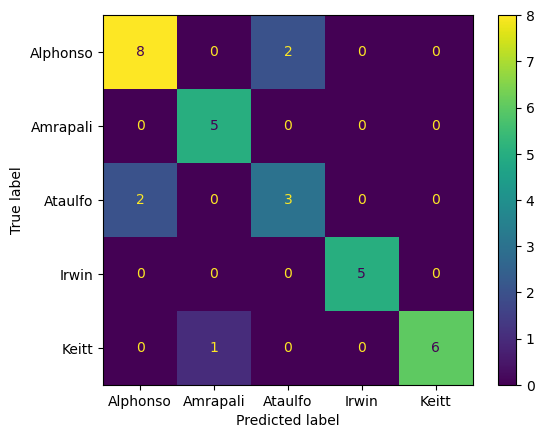

In [63]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_predicted)

display_labels = []

for i in range(0, 5):
    display_labels.append(class_names[i])
    

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = display_labels)

cm_display.plot()
plt.show() 